# Cs/Th analysis with KDSTs -- run 6955 (standard Dorothea: PMT energy, SiPM-based fiducial cuts)

In [1]:
run_number  = 6955
input_path  = "/Users/jrenner/local/data/NEW/6955/hdf5/kdst/trigger1/"

save_dir = "fig_10bar_6955_pmtsonly"
ftype = "pdf"

# Peak energies
E_xKalpha = (29.112*0.00261 + 29.461*25.6 + 29.782*47.4)/(0.00261 + 25.6 + 47.4)
E_xKbeta  = (33.562*4.35 + 33.624*8.40 + 33.881*0.085 + 34.419*2.54 + 34.496*0.492)/(4.35 + 8.40 + 0.085 + 2.54 + 0.492)
E_Kr      = 41.543
E_Cs      = 661.657
E_descape = 1592.535
E_Tl      = 2614.533
print("""
E_xKalpha = {}
E_xKbeta = {}
E_Kr = {}
E_Cs = {}
E_descape = {}
E_Tl = {}
""".format(E_xKalpha,E_xKbeta,E_Kr,E_Cs,E_descape,E_Tl))


E_xKalpha = 29.669410207662434
E_xKbeta = 33.76268210751875
E_Kr = 41.543
E_Cs = 661.657
E_descape = 1592.535
E_Tl = 2614.533



In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.core.core_functions as coref

import textwrap
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

from glob import glob
from   scipy.interpolate                       import interp1d
from   scipy.optimize                          import curve_fit
from   invisible_cities.database               import load_db

# Formatting options
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

In [4]:
import invisible_cities.reco.dst_functions  as dstf
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

# A linear function mx + b
def flinear(x, m, b):
    return m*x + b

# A quadratic function mx**2 + b
def fquadratic(x, m, b):
    return m*x**2 + b

# A sqrt function a*sqrt(x)
def fsqrt(x, a, b):
    return a*x**0.5 + b

# A 2nd order polynomial
def poly2(x, a, b, c):
    return a*x**2 + b*x + c

# Fit function for energy resolution.
def fres(x, a, b):
    return a + b/x**0.5

# Return resolution extrapolated to Qbb
def reso(values,epeak):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (epeak/2458)**0.5

# Returns text output for Gaussian fit function
def gausstext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}""".format(*values[1:]))

In [5]:
input_dst_filenames = glob(input_path + '*h5')
input_dst_filenames = sorted(input_dst_filenames, key=lambda s: int(s.split('_')[-6]))
print("Found {} files.".format(len(input_dst_filenames)))

Found 1465 files.


In [6]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [7]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [8]:
dst1s1 = dst_full[in_range(dst_full.nS1,1,2)]
dst1s2 = dst1s1[in_range(dst1s1.nS2,1,2)]

In [9]:
A_evtnum = dst1s2['event'].values
A_E0_kdst = dst1s2['S2e'].values
A_xavg = dst1s2['X'].values
A_yavg = dst1s2['Y'].values
A_zavg = dst1s2['Z'].values
A_zwidth = dst1s2['S2w'].values

## Uncorrected energy spectrum

Text(0, 0.5, 'Counts/bin')

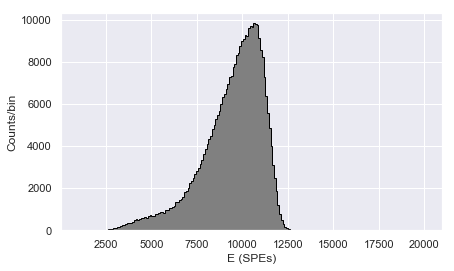

In [10]:
# Energy spectrum for Kr events.
nbins = 200

plt_rng_Cs = [1000,20000]
nbins_Cs = 150

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
y, x, _ = plt.hist(A_E0_kdst, nbins, range=plt_rng_Cs, **hargs)
plt.xlabel('E (SPEs)')
plt.ylabel('Counts/bin')

## Spatial distribution

Central point is (0,0)


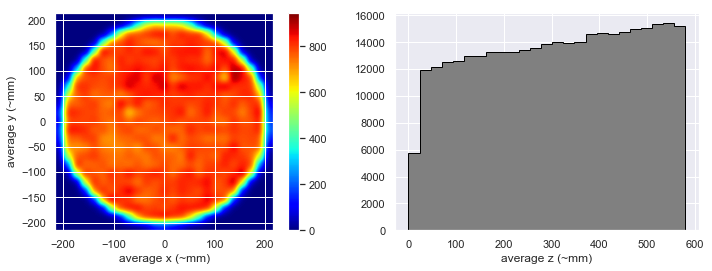

In [11]:
# Plot the spatial distribution of Kr events.
cuts_xyz_Kr = (A_E0_kdst > 5000) & (A_E0_kdst < 12500)
fscale = 1.
x0 = 0
y0 = 0
print("Central point is ({},{})".format(x0,y0))

# Create a new variable for radius
A_radius = fscale*((A_xavg-x0)**2 + (A_yavg-y0)**2)**0.5

cuts_xyz = cuts_xyz_Kr
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-(A_yavg[cuts_xyz]-y0)*fscale, (A_xavg[cuts_xyz]-x0)*fscale, bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (~mm)")
plt.ylabel("average y (~mm)")

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (~mm)")

plt.savefig("{}/CSTH_xyzdist_Kr.{}".format(save_dir,ftype), bbox_inches='tight')

## Energy vs. z-length

Kr peak, slope for correction: -130.18726982611923; intercept: 12477.848373142646


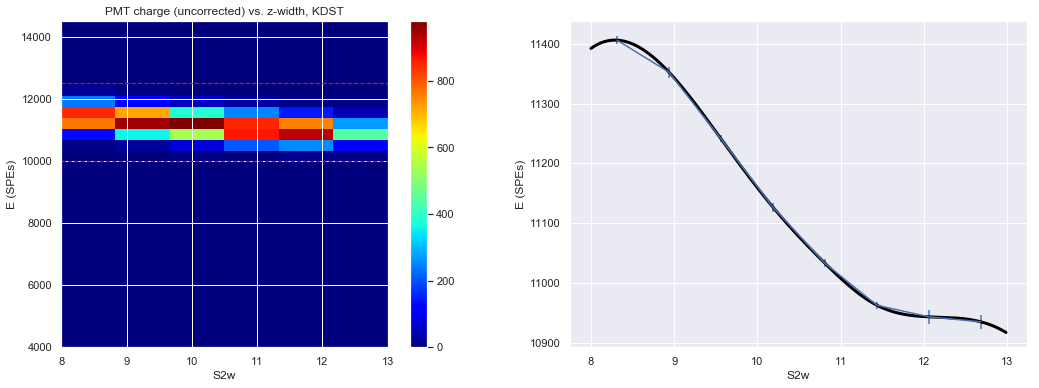

In [12]:
# Energy vs. z-length
cuts_T = (A_E0_kdst > 5000) & (A_E0_kdst < 12500) & (A_radius < 50) & (A_zavg < 500)
corrected = False

nbins_prof = 8
nbins_E = 30
nbins_ltrk = 6
    
Thist_min_Kr = 8
Thist_max_Kr = 13
Ehist_min_Kr = 10000
Ehist_max_Kr = 12500
plt_rng_Tlow_Kr = Thist_min_Kr
plt_rng_Thigh_Kr = Thist_max_Kr
plt_rng_Elow_Kr = 4000
plt_rng_Ehigh_Kr = 14500

Tprof_Kr, Eprof_Kr, Eerr_Kr = fitf.profileX(A_zwidth[cuts_T],A_E0_kdst[cuts_T],nbins=nbins_prof,xrange=(Thist_min_Kr,Thist_max_Kr),yrange=(Ehist_min_Kr,Ehist_max_Kr))
prof_Kr = interp1d(Tprof_Kr, Eprof_Kr, fill_value="extrapolate", kind="cubic")

# Fit to determine the correction functions.
p_Kr, V_Kr = curve_fit(flinear, Tprof_Kr, Eprof_Kr, sigma=Eerr_Kr, absolute_sigma=True)
m_Kr = p_Kr[0]
b_Kr = p_Kr[1]
sigma_m_Kr = V_Kr[0,0]**0.5
sigma_b_Kr = V_Kr[1,1]**0.5
sigma2_mb_Kr = V_Kr[0,1]
xfit_Kr = np.arange(Tprof_Kr[0],Tprof_Kr[-1],1.)
pfit_Kr = np.poly1d([m_Kr, b_Kr])
print("Kr peak, slope for correction: {}; intercept: {}".format(m_Kr, b_Kr))

fig = plt.figure()
fig.patch.set_alpha(0.0)
fig.set_figheight(6.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(121);
h, x, y = np.histogram2d(-A_E0_kdst[cuts_T], A_zwidth[cuts_T], bins=[nbins_E, nbins_ltrk], range=[[-plt_rng_Ehigh_Kr,-plt_rng_Elow_Kr],[plt_rng_Tlow_Kr,plt_rng_Thigh_Kr]])
plt.imshow(h, extent=[plt_rng_Tlow_Kr,plt_rng_Thigh_Kr,plt_rng_Elow_Kr,plt_rng_Ehigh_Kr], interpolation = "none", cmap='jet', aspect=(plt_rng_Thigh_Kr-plt_rng_Tlow_Kr)/(plt_rng_Ehigh_Kr-plt_rng_Elow_Kr))
ax1.axhline(y=Ehist_min_Kr,c="red",linewidth=1.2,linestyle='dashed')
ax1.axhline(y=Ehist_max_Kr,c="red",linewidth=1.2,linestyle='dashed')
plt.colorbar()
plt.title("PMT charge (uncorrected) vs. z-width, KDST")
plt.ylim([plt_rng_Elow_Kr,plt_rng_Ehigh_Kr])
plt.xlim([plt_rng_Tlow_Kr,plt_rng_Thigh_Kr])
plt.xlabel('S2w')
plt.ylabel('E (SPEs)')

ax2 = fig.add_subplot(122);
ax2.errorbar(Tprof_Kr,Eprof_Kr,yerr=Eerr_Kr)
ax2.plot(np.arange(plt_rng_Tlow_Kr,plt_rng_Thigh_Kr,0.01),prof_Kr(np.arange(plt_rng_Tlow_Kr,plt_rng_Thigh_Kr,0.01)),'-',color='black',linewidth=3)
#ax2.plot(xfit_Kr, pfit_Kr(xfit_Kr), '--', color='red', label="m/b = {:.2f} $\\times 10^{{-4}}$".format(m_Kr/b_Kr*1e4))
#plt.legend(loc=1, fontsize=14)
plt.xlabel('S2w')
plt.ylabel('E (SPEs)')

plt.savefig("{}/CSTH_E_vs_zlen_keV_Kr.{}".format(save_dir,"png"), bbox_inches='tight')

## Uncorrected spectrum with fiducial cuts

Text(0, 0.5, 'Counts/bin')

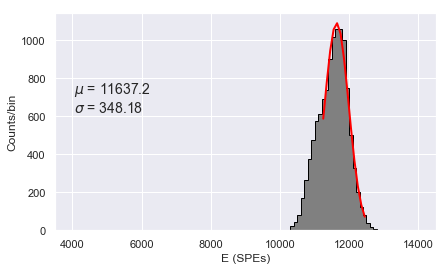

In [13]:
# Energy spectrum with fiducial cuts.
nbins = 100
cuts_E = (A_radius < 100) & (A_zavg < 100)

plt_rng_Kr = [4000,14000]
nbins_Kr = 150
text_x = 1.01*plt_rng_Kr[0]

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(15.0)

fit_rng_low = 11200
fit_rng_high = 12500
fit_gauss_A = 420
fit_gauss_mu = 11500
fit_gauss_sigma = 2000

ax1 = fig.add_subplot(121)
y0, x0, _ = plt.hist(A_E0_kdst[cuts_E], nbins, range=plt_rng_Kr, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(fitf.gauss, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma))
plt.plot(x, f.fn(x), "red", linewidth=2)
plt.text(text_x, 3.5*max(y)/6, gausstext(f.values[0:3],E_Kr),fontsize=14)
plt.xlabel('E (SPEs)')
plt.ylabel('Counts/bin')